# Advanced Numerical Analysis

## Exercise 52 - Heat flow through a thin strip

*Heat flow through a thin strip may be modeled by the heat equation* $u_t = c u_{xx}$ *on* $[0, T] \times [-L, L]$ *with initial conditions* $u(0, x) = u_0(x)$ *for* $x \in [-L, L]$ *and spatial boundary conditions* $u(t, x) = 0$ *for* $|x| = L.$ *For the numerical examples, let* $c = 1, L = \pi,$ *and* $T = 10.$

$\textrm{(i)} \quad$ *Write a program for finding* $u$ *given* $u_0,$ *using the method of lines with constant step size* $h$ *in time and finite differences for the spatial discretization, with constant mesh size* $\frac{L}{N}.$ *Allow solving the resulting ODE with any of the three half-step methods. In the implicit case (Crank–Nicholson method), use a sparse representation of the linear system.*

The function `solve_heat` defined below solves the heat equation

$$\begin{cases}
u_t = c u_{xx} \quad \textrm{on} \ [T_1, T_2] \times [L_1, L_2] \\
u(T_1,x) = u_0(x) \quad \forall x \in [L_1, L_2] \\
u(t,L_1) = a(t),\ u(t,L_2) = b(t) \quad \forall t \in [T_1, T_2]
\end{cases}$$

on a discretized rectangle with the following parameters:

`c` : float\
coefficient $c$ of heat equation $u_t = c u_{xx}$

`u0` : function handle\
function in variable $x$ of initial condition $u(T_1, x) = u_0(x)$

`a` : function handle\
function in variable $t$ of boundary condition $u(t, L_1) = a(t)$

`b` : function handle\
function in variable $t$ of boundary condition $u(t, L_2) = b(t)$

`t` : array\
discretized time interval $[T_1 = t_1,\, t_2,\, \dots,\, t_{M-1},\, t_M = T_2]$ of size $1 \times M$

`x` : array\
discretized space interval $[L_1 = x_1,\, x_2,\, \dots,\, x_{N-1},\, x_N = L_2]$ of size $1 \times N$

`method` : {1, 2, 3}, default 1\
first, second or third half step method to be used for solving the ODE

In [1]:
function u = solve_heat(c, u0, a, b, t, x, method = 1)
    
    # initialize solution array
    M = length(t);
    N = length(x);
    u = zeros(N, M);
    
    # add initial and boundary values to solution array
    u(:, 1) = u0(x);
    u(1, :) = a(t);
    u(end, :) = b(t);
    
    # step sizes for time and space directions
    h = t(2:end) - t(1:end-1);
    k = x(2:end) - x(1:end-1);
        
    # construction of system matrix
    diagonal = -(k(1:end-1) + k(2:end)) ./ k(1:end-1) ./ k(2:end).^2;
    subdiagonal = 1 ./ k(1:end-1) ./ k(2:end);
    superdiagonal = 1 ./ k(2:end-1).^2;
    F = spdiags(diagonal', 0, N-2, N-2);
    F = spdiags([subdiagonal,0]', -1, F);
    F = spdiags([0,superdiagonal]', 1, F);
    F *= c;
    
    # function of ODE
    function U_prime = f(t, U)
        U_prime = F * U;
        U_prime(1) += c * a(t) / k(1) / k(2);
        U_prime(end) += c * b(t) / k(end)^2;
    endfunction
    
    # first half-step method: modified Euler method
    if method == 1
        for i = 1 : M-1
            temp = u(2:end-1,i) + h(i)/2 * f(t(i), u(2:end-1,i));
            u(2:end-1,i+1) = u(2:end-1,i) + h(i) * f(t(i) + h(i)/2, temp);
        endfor
        return
    
    # second half-step method: method of Heun
    elseif method == 2
        for i = 1 : M-1
            temp = u(2:end-1,i) + h(i) * f(t(i), u(2:end-1,i));
            u(2:end-1,i+1) = u(2:end-1,i) + h(i)/2 * (f(t(i), u(2:end-1,i)) + f(t(i+1), temp));
        endfor
        return
    
    # third half-step method: implicit midpoint method
    elseif method == 3
        for i = 1 : M-1
            # solves the implicit equation as a linear system A u_(i+1) = y
            A = speye(N-2) - h(i)/2 * F;
            y = u(2:end-1,i) + h(i)/2 * F * u(2:end-1,i);
            y(1) += h(i) * c * a(t(i) + h(i)/2) / k(1) / k(2);
            y(end) += h(i) * c * b(t(i) + h(i)/2) / k(end)^2;
            
            u(2:end-1,i+1) = A \ y;
        endfor
        return
        
    else
        error("Not a valid method. Choose 1, 2 or 3 for a half-step method.")
    endif
    
endfunction

$$ $$
$\textrm{(ii)} \quad$ *Show that* $u(t, x) = \sin(x) e^{-t} + \sin(9x) e^{-81t}$ *solves the heat equation for the initial conditions* $u_0(x) = \sin(x) + \sin(9x).$


By direct computation of the derivatives we show that $u$ is indeed a solution of the heat equation.

$$\begin{align*}
u_t(t,x) &= -\sin(x) e^{-t} - 81 \sin(9x) e^{-81t} \\
u_x(t,x) &= \cos(x) e^{-t} + 9 \cos(9x) e^{-81t} \\
u_{xx}(t,x) &= -\sin(x) e^{-t} - 81 \sin(9x) e^{-81t} \\
\Rightarrow u_t &= u_{xx}
\end{align*}$$

Since $u(0,x) = \sin(x) + \sin(9x)$ the initial condition is also satisfied.

Below the solver is tested on this example and the exact and approximate solutions plotted.

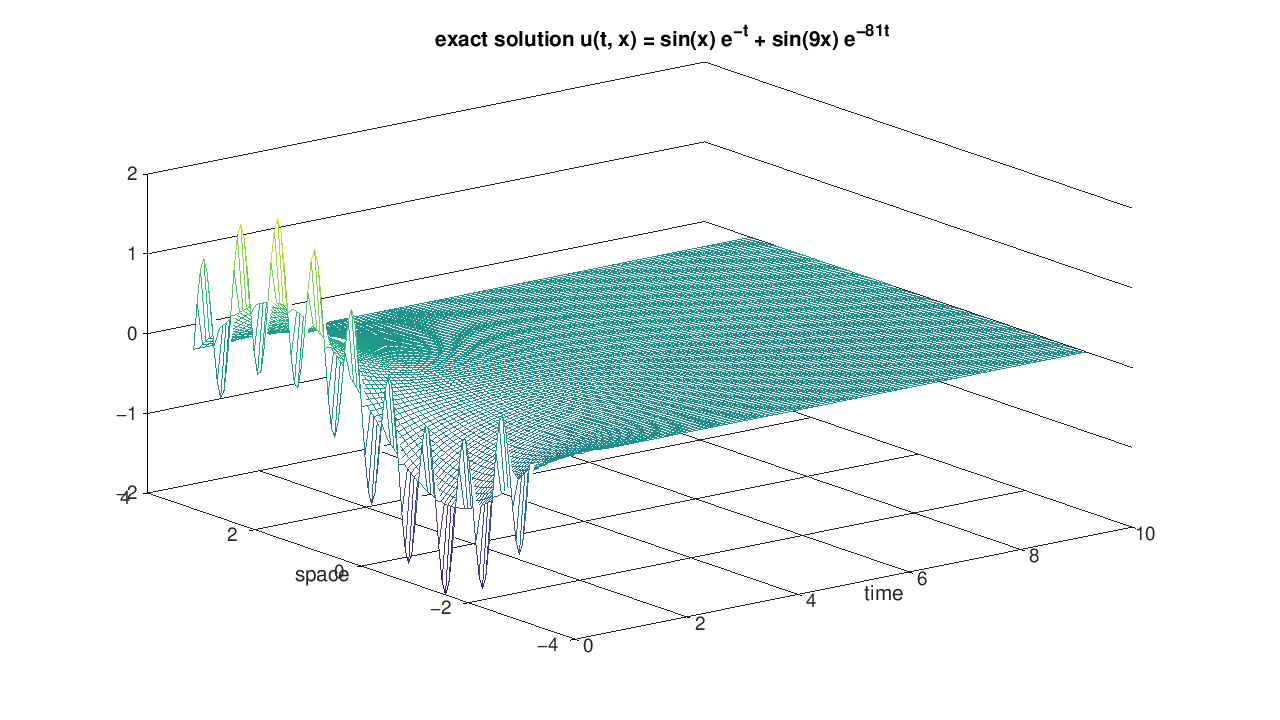

In [13]:
%plot -s 1280,720

L = pi;
T = 10;
c = 1;

h = 0.1;
N = 50;
t = 0 : h : T;
x = -L : L/N : L;

u = @(t, x) sin(x) .* exp(-t) + sin(9*x) .* exp(-81*t);
[tt, xx] = meshgrid(t, x);
exact = u(tt, xx);

mesh(t, x, exact);
title("exact solution u(t, x) = sin(x) e^{-t} + sin(9x) e^{-81t}");
xlabel("time");
ylabel("space");

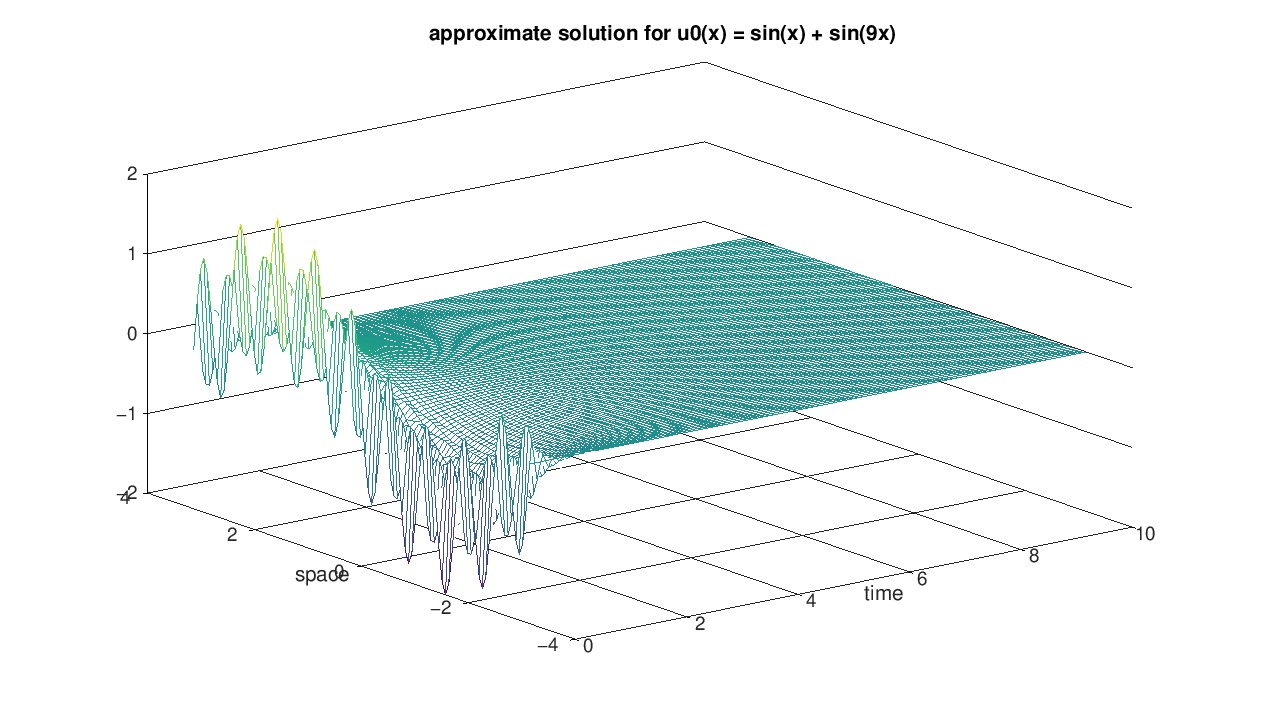

In [14]:
a = @(t) zeros(size(t));
b = a;
u0 = @(x) sin(x) + sin(9*x);

approx = solve_heat(c, u0, a, b, t, x, 3);

mesh(t, x, approx);
title("approximate solution for u_0(x) = sin(x) + sin(9x)");
xlabel("time");
ylabel("space");

$$ $$
$\textrm{(iii)} \quad$ *For each pair* $(N,$ `method`$)\, \in \{ 10, 100, 1000 \} \times \{ 1, 2, 3 \},$ *find the largest time step* $h = 2^{-k}$ *for which the error of the solution in the maximum norm is less than 1.2 times the error of the step size* $h = 2^{-k-1}.$ *Interpret the findings.*

In [15]:
triples = [];
disp("   N | method | time step | maximum error");
for N = [10, 100, 1000]
    for method = 1 : 3
        old_error = 0;
        for exponent = 1 : 5
            t = 0 : 1/2^exponent : T;
            x = -L : L/N : L;
            
            [tt, xx] = meshgrid(t, x);
            exact = u(tt, xx);
            
            approx = solve_heat(c, u0, a, b, t, x, method);
            new_error = max(max(abs(exact - approx)));
                        
            if old_error != 0 && old_error <= 1.2 * new_error
                printf("%4d |    %d   |   2^(-%d)  | %13.3e\n", N, method, exponent-1, old_error);
                triples = [triples; [N, method, exponent-1]];
                break
            endif
            old_error = new_error;
        endfor
    endfor
endfor

   N | method | time step | maximum error
  10 |    1   |   2^(-1)  |     8.731e+44
  10 |    2   |   2^(-1)  |     8.731e+44
  10 |    3   |   2^(-4)  |     1.112e-01
 100 |    1   |   2^(-1)  |    1.907e+111
 100 |    2   |   2^(-1)  |    1.907e+111
 100 |    3   |   2^(-1)  |     9.118e-01
1000 |    1   |   2^(-1)  |    1.755e+192
1000 |    2   |   2^(-1)  |    1.755e+192
1000 |    3   |   2^(-1)  |     9.124e-01


Since the first two half-step methods produce such large errors for the large step sizes but still satisfy the required condition, we manually set them to a more appropriate magnitude except for $N=1000,$ where that would exceed reasonable computation times. We notice that with smaller step sizes in space the step sizes in time have to be smaller as well.

The third half-step method is much more stable than the first two. Large step sizes in time already produce acceptable results.

In [16]:
triples(1,3) = 6;
triples(2,3) = 6;
triples(4,3) = 11;
triples(5,3) = 11;

In [17]:
t = {};
x = {};
approx_iii = {};
for i = 1 : length(triples)
    t{i} = 0 : 1/2^triples(i,3) : T;
    x{i} = -L : L/triples(i,1) : L;
    approx_iii{i} = solve_heat(c, u0, a, b, t{i}, x{i}, triples(i,2));
endfor

$$ $$
$\textrm{(iv)} \quad$ *For the step sizes found in* $\textrm{(iii)},$ *solve the problem for* $u_0(x) = x - \pi \, \textrm{sign}(x).$


In [18]:
u0 = @(x) x - pi * sign(x);
approx_iv = {};

for i = 1 : length(triples)
    approx_iv{i} = solve_heat(c, u0, a, b, t{i}, x{i}, triples(i,2));
endfor

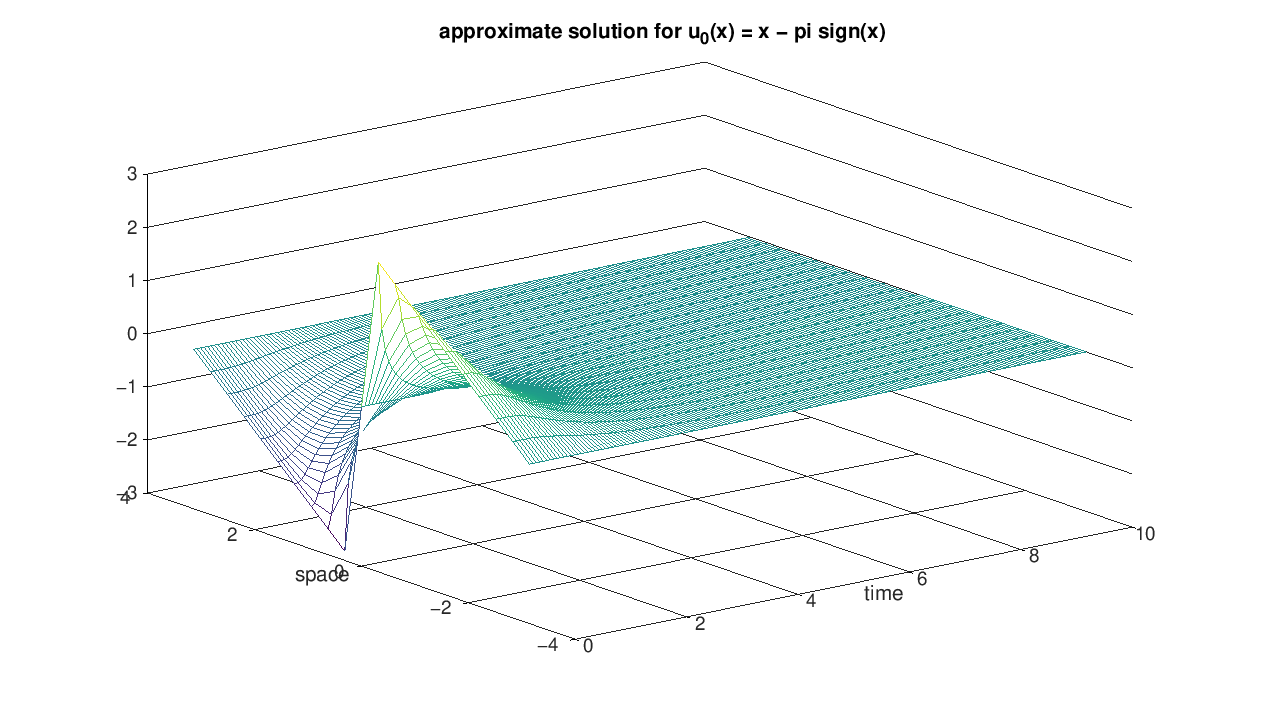

In [19]:
i = 3;
mesh(t{i}, x{i}, approx_iv{i});
title("approximate solution for u_0(x) = x - pi sign(x)");
xlabel("time");
ylabel("space");

$$ $$
$\textrm{(v)} \quad$ *Describe the effect of time on the solutions of* $\textrm{(iii)}$ *and* $\textrm{(iv)}.$

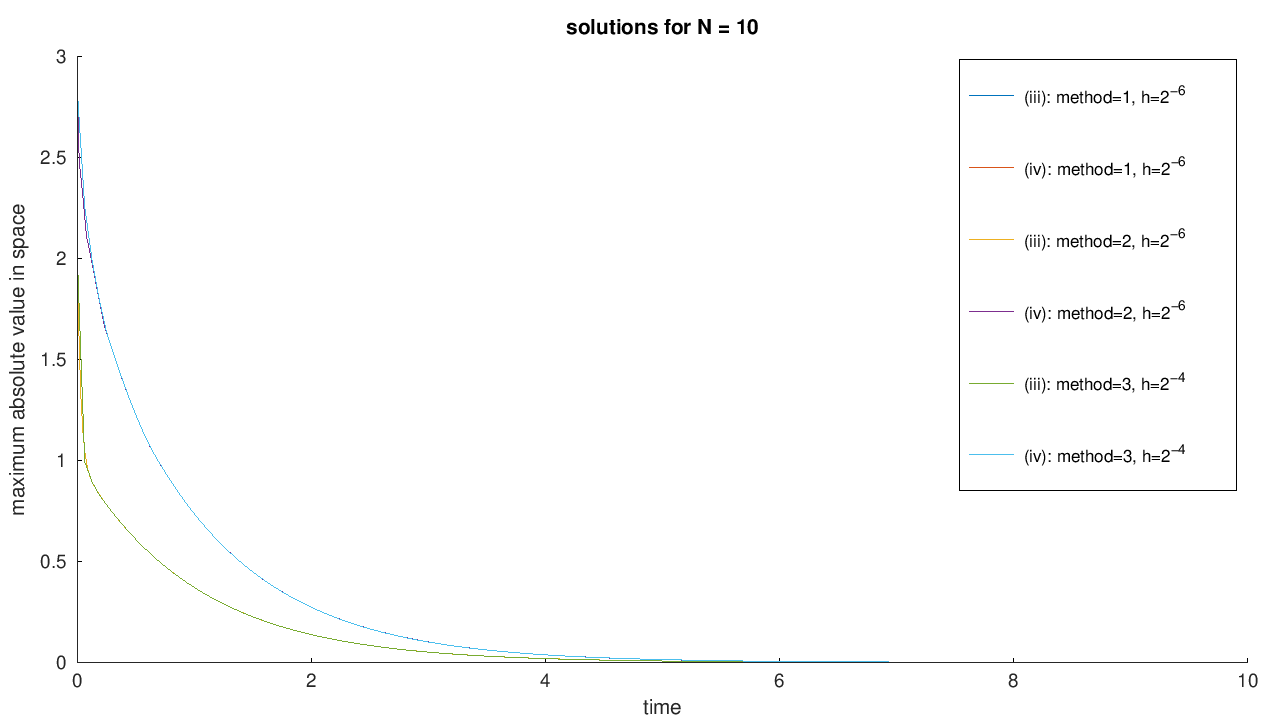

In [20]:
N = 10;
hold on;
for i = 1 : length(triples)
    if triples(i,1) == N
        displayname_iii = sprintf("(iii): method=%d, h=2^{-%d}", triples(i,2), triples(i,3));
        displayname_iv = sprintf("(iv): method=%d, h=2^{-%d}", triples(i,2), triples(i,3));
        plot(t{i}, max(approx_iii{i}), "displayname", displayname_iii);
        plot(t{i}, max(approx_iv{i}), "displayname", displayname_iv);
    endif
endfor
title_string = sprintf("solutions for N = %d", N);
title(title_string);
xlabel("time");
ylabel("maximum value in space");
legend();

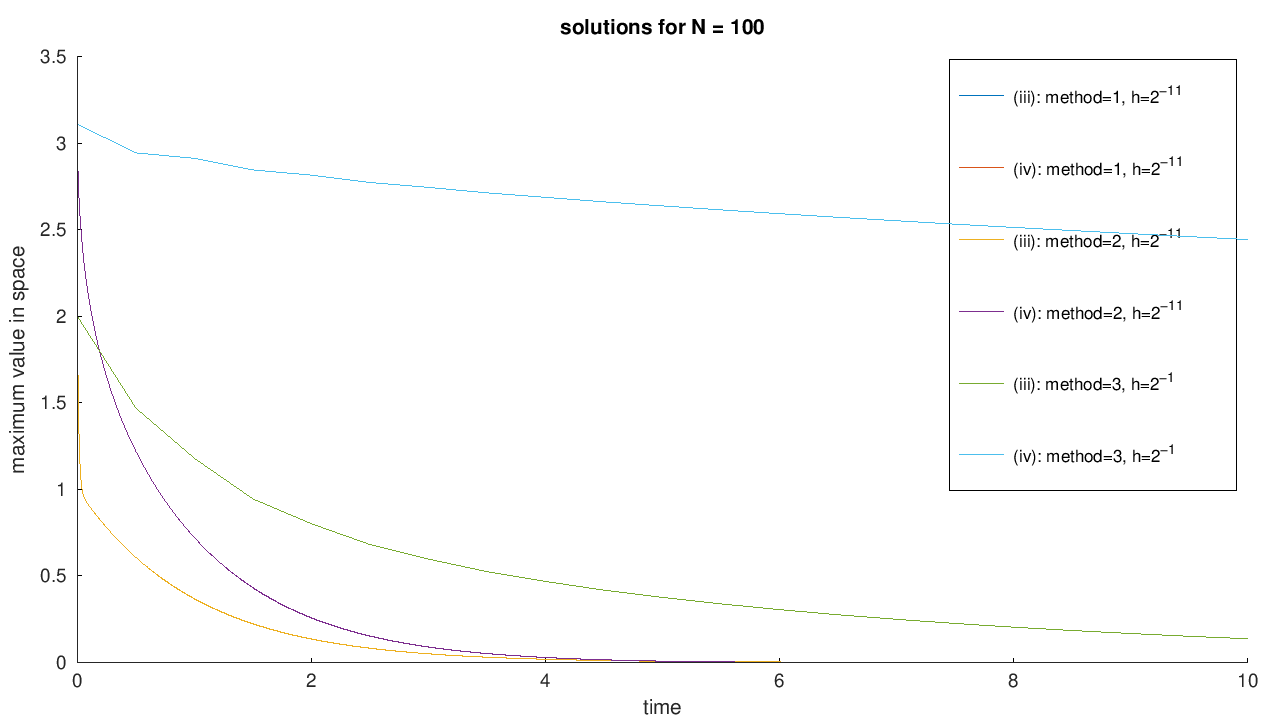

In [24]:
N = 100;
hold on;
for i = 1 : length(triples)
    if triples(i,1) == N
        displayname_iii = sprintf("(iii): method=%d, h=2^{-%d}", triples(i,2), triples(i,3));
        displayname_iv = sprintf("(iv): method=%d, h=2^{-%d}", triples(i,2), triples(i,3));
        plot(t{i}, max(approx_iii{i}), "displayname", displayname_iii);
        plot(t{i}, max(approx_iv{i}), "displayname", displayname_iv);
    endif
endfor
title_string = sprintf("solutions for N = %d", N);
title(title_string);
xlabel("time");
ylabel("maximum value in space");
legend();

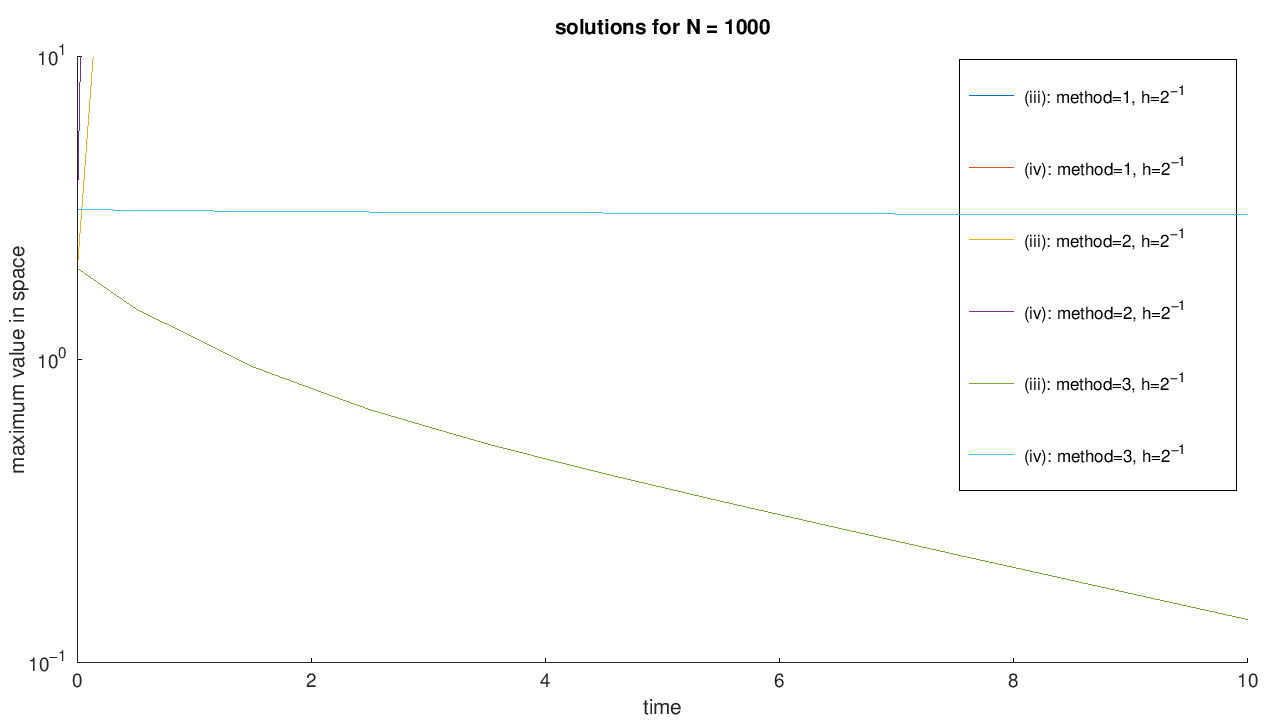

In [36]:
N = 1000;
hold on;
for i = 1 : length(triples)
    if triples(i,1) == N
        displayname_iii = sprintf("(iii): method=%d, h=2^{-%d}", triples(i,2), triples(i,3));
        displayname_iv = sprintf("(iv): method=%d, h=2^{-%d}", triples(i,2), triples(i,3));
        semilogy(t{i}, max(approx_iii{i}), "displayname", displayname_iii);
        semilogy(t{i}, max(approx_iv{i}), "displayname", displayname_iv);
    endif
endfor
title_string = sprintf("solutions for N = %d", N);
title(title_string);
xlabel("time");
ylabel("maximum value in space");
legend();
axis([0, T, 1e-1, 1e1])

$$ $$
Theoretically the solutions should go to 0 for $t \rightarrow \infty$ and become instantly smooth. For small space steps the first and second half-step method capture this behavior altough they need very small time steps. But since for $N=1000$ the time steps were not chosen small enough they explode in time and go to infinity. Should they be implemented correctly then these two half-step methods are not suitable to solve such systems for small step sizes in space using the method of lines.

The third half-step method on the other hand is very stable and shows the dynamic even for large steps in time. Since the implicit equation can be solved as a sparse linear system this method is not much more computationally taxing compared to the other two and is thus to be preferred.